# 检验趋势策略的趋势性

参考文献：https://mp.weixin.qq.com/s/Mhu2SB6AMzga_Y1pvwM6PQ

In [2]:
import sys
sys.path.append('C:\\Users\\xpy\\work\\strategies2py\\AprilQuant')
import warnings
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import empyrical

from backtest.indicators import ATR, AllNaError
from backtest.return_rate_calculations import (
    cal_avg_cum_ret, 
    avg_cum_ret_from_cursor, 
    cal_ret, 
    cum_ret_from_doc
)
from backtest.check_for_momentum import (
    get_cum_ret_dict,
    cal_strategy_overall_tendency,
    ATR_position_sizing
)
from utils import query, plot_curves
from consts import C_DAILY

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


cum_ret_dict = get_cum_ret_dict('DMAC', 'daily', break_in=0, use_real_price=False)

## 1.检验假设：策略在所有品种上具有相同周期的动量效应
检验方法与参考文献相同。  
可以发现，对于任何长度的历史期和预测期，历史期与预测期收益率相关系数显著为负的比例明显高于相关系数显著为正的比例，证明策略在所有品种相同周期上有具有更强的反转效应而非动量效应。假设不能成立。

In [3]:
hist_len_rng = (240, 480, 720, 960, 1200)
pred_len_rng = (20, 60, 120, 240)

params = [
    (hist_len, pred_len) 
    for pred_len in pred_len_rng 
    for hist_len in hist_len_rng
]
lines = []
for param in params:
    line = cal_strategy_overall_tendency(cum_ret_dict, hist_len=param[0], pred_len=param[1])
    lines.append(line)
summary = pd.DataFrame(lines).sort_values('hist_len')
display(summary)

,hist_len,pred_len,category_num,sig_pos_related,sig_neg_related,successful_prediction
0,240,20,48,0.041667,0.625000,0.562500
5,240,60,46,0.065217,0.673913,0.478261
10,240,120,45,0.155556,0.755556,0.533333
15,240,240,44,0.159091,0.772727,0.386364
1,480,20,42,0.023810,0.690476,0.476190
6,480,60,42,0.166667,0.761905,0.428571
11,480,120,39,0.128205,0.820513,0.384615
16,480,240,37,0.189189,0.810811,0.405405
2,720,20,36,0.027778,0.750000,0.583333
17,720,240,33,0.212121,0.666667,0.424242


## 2. 多品种策略表现
由于动量效应不明显，不考虑动态筛选品种。  
使用固定比例法调整各品种仓位。当ATR移动平均周期为120天,180天,240天时，调整仓位后，策略收益率与Sharpe比率有所提升。

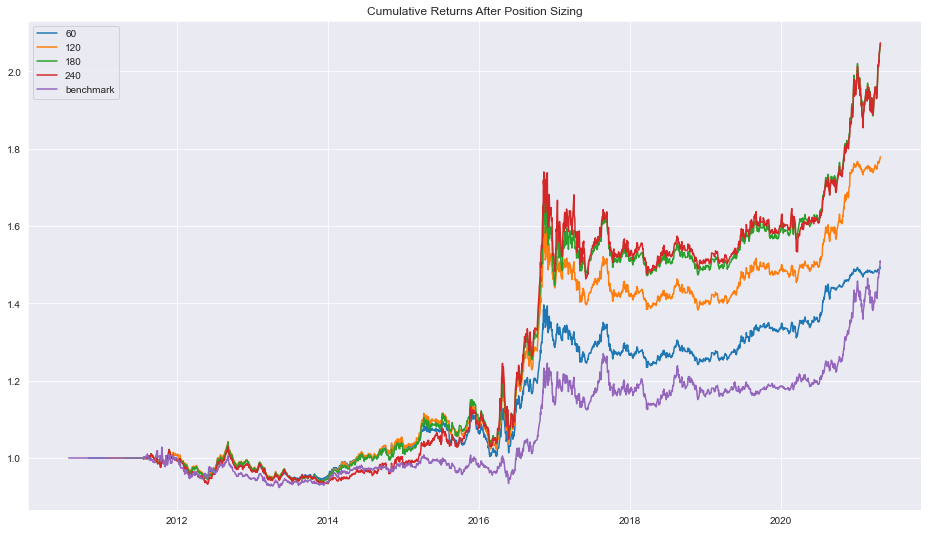

In [4]:
atr_length_rng = (60, 120, 180, 240)

weighted_cum_rets = [
    ATR_position_sizing(cum_ret_dict, 'daily', atr_length, atr_length) 
    for atr_length in atr_length_rng
]
benchmark = cal_avg_cum_ret(cum_ret_dict.values())

plot_curves([*weighted_cum_rets, benchmark], 'Cumulative Returns After Position Sizing', [*atr_length_rng, 'benchmark'])

In [5]:
for atr_length, cum_ret in zip([*atr_length_rng, None], weighted_cum_rets + [benchmark]):
    sr = empyrical.sharpe_ratio(cal_ret(cum_ret))[0]
    output_string = f'使用 {atr_length} 期ATR调整仓位: ' if atr_length is not None \
                else '不调整仓位：            '
          
    output_string += f'累计收益率为 {cum_ret.cum_ret.tolist()[-1]} '
    output_string += f'Sharpe Ratio 为 {sr}'
    print(output_string)

使用 60 期ATR调整仓位: 累计收益率为 1.4933019793630822 Sharpe Ratio 为 0.4409097428319931
使用 120 期ATR调整仓位: 累计收益率为 1.7789598673276743 Sharpe Ratio 为 0.5760149157138253
使用 180 期ATR调整仓位: 累计收益率为 2.069937459251845 Sharpe Ratio 为 0.6805358867492917
使用 240 期ATR调整仓位: 累计收益率为 2.073947778494646 Sharpe Ratio 为 0.7410843343325885
不调整仓位：            累计收益率为 1.5067358171041707 Sharpe Ratio 为 0.5457275656430365
